In [1]:
import argparse
import datetime
import numpy as np
import os
import time
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from util.crop import center_crop_arr
import util.misc as misc
from util.misc import NativeScalerWithGradNormCount as NativeScaler
from util.loader import CachedFolder

from models.vae import AutoencoderKL
from models import mar
from engine_mar import train_one_epoch, evaluate
import copy

from torchvision.utils import save_image
from util import download
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
model_type = "mar_base"
num_sampling_steps_diffloss = 100

if model_type == "mar_base":
  diffloss_d = 6
  diffloss_w = 1024
elif model_type == "mar_large":
  diffloss_d = 8
  diffloss_w = 1280
elif model_type == "mar_huge":
  diffloss_d = 12
  diffloss_w = 1536
else:
  raise NotImplementedError

model = mar.__dict__[model_type](
  buffer_size=64,
  diffloss_d=diffloss_d,
  diffloss_w=diffloss_w,
  num_sampling_steps=str(num_sampling_steps_diffloss)
).to(device)

state_dict = torch.load("pretrained_models/mar/{}/checkpoint-last.pth".format(model_type))["model_ema"]
model.load_state_dict(state_dict)
model.eval() # important!

vae = AutoencoderKL(embed_dim=16, ch_mult=(1, 1, 2, 2, 4), ckpt_path="pretrained_models/vae/kl16.ckpt").cuda().eval()

Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
Loading pre-trained KL-VAE
Missing keys:
[]
Unexpected keys:
[]
Restored from pretrained_models/vae/kl16.ckpt


In [3]:
# Set user inputs:
seed = 0 
torch.manual_seed(seed)
np.random.seed(seed)
num_ar_steps = 64
cfg_scale = 4
cfg_schedule = "constant"
temperature = 1.0
class_labels = 207, 360, 388, 113, 355, 980, 323, 979
samples_per_row = 4

In [4]:
with torch.cuda.amp.autocast():
  sampled_tokens = model.sample_tokens(
      bsz=len(class_labels),
      num_iter=num_ar_steps,
      cfg=cfg_scale,
      cfg_schedule=cfg_schedule,
      labels=torch.Tensor(class_labels).long().cuda(),
      temperature=temperature,
      progress=True
  )

  sampled_images = vae.decode(sampled_tokens / 0.2325)

100%|██████████| 64/64 [00:20<00:00,  3.08it/s]


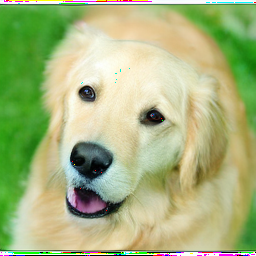

In [5]:
tensor = sampled_images[0]
image = np.transpose(np.array((tensor.cpu().detach()+1)*255/2), (1, 2, 0)).astype(np.uint8)
display(Image.fromarray(image))

In [ ]:
# Save and display images:
save_image(sampled_images, "sample.png", nrow=int(samples_per_row), normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)